# Compute correlation function with error bars using jackknife

In [1]:
import time
from tqdm.notebook import tqdm

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction, BoxSubsampler, setup_logging

import catalog_data
import density_split

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')

### Generate random catalog

In [4]:
# Generate random catalogs to compare catalog with when computing correlation function
def generate_catalogs(size, boxsize, offset, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
    return positions

randoms_positions = generate_catalogs(size=6*catalog.size, boxsize=(catalog.boxsize,)*3, offset=(-catalog.boxsize/2.,)*3)

### Split in subsamples for jackknife variance estimation

In [5]:
subsampler = BoxSubsampler(positions=catalog.positions, boxsize=np.full(3, catalog.boxsize), boxcenter=np.full(3, catalog.boxcenter), nsamples=1e3)
labels = subsampler.label(positions=catalog.positions)

data_samples = subsampler.label(catalog.positions)
randoms_samples = subsampler.label(randoms_positions)

## Compute s-mu two point correlation function

In [ ]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))

result = TwoPointCorrelationFunction('smu', edges, 
                                     data_positions1=catalog.positions, randoms_positions1=randoms_positions,
                                     data_samples1=data_samples, randoms_samples1=randoms_samples,
                                     engine='corrfunc', nthreads=128,
                                     los = 'x')

[000001.83]  04-28 12:10  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_jackknife.JackknifeLandySzalayTwoPointEstimator'>.
[000001.84]  04-28 12:10  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000155.13]  04-28 12:13  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[001165.14]  04-28 12:29  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


### Save result

In [ ]:
RSD_string = ''
if catalog.rsd:
    RSD_string = '_wRSD'
    
result.save(output_dir+catalog.name+RSD_string+'_corrfunc_randomx6')

[023270.56]  04-20 16:07  JackknifeLandySzalayTwoPointEstimator INFO     Saving /feynman/home/dphp/mp270220/outputs/AbacusSummit_base_c000_ph000_z1.175_corrfunc_randomx6.


### Load

In [6]:
result = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_highbase_c000_ph100_z1.175'+'_corrfunc_randomx6.npy')

In [9]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2)
nells = len(ells)

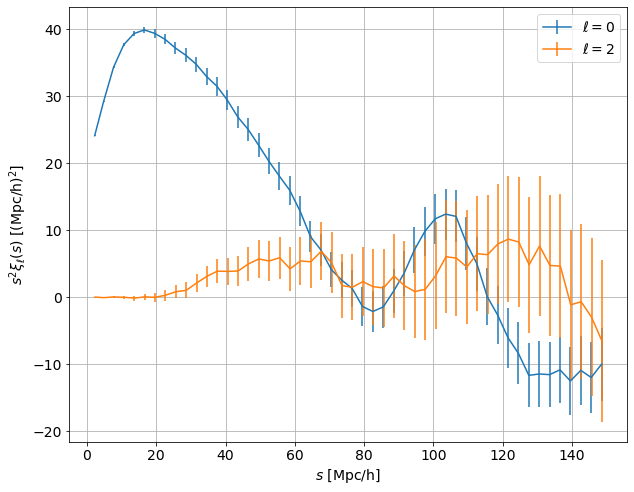

In [10]:
s, xiell, cov = result.get_corr(ells=ells, return_sep=True, return_cov=True)
std = np.array_split(np.diag(cov)**0.5, nells)

for ill,ell in enumerate(ells):
    plt.errorbar(s+ill*0.1, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='$\ell = {:d}$'.format(ell))
plt.legend()
plt.grid(True)
plt.xlabel(r'$s$ [Mpc/h]')
plt.ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/$h$)^{2}$]')
plt.show()